# Load libaries

In [1]:
install.packages("ggplot2")
install.packages("gridExtra")
install.packages("caret")
library(ggplot2)
library(gridExtra)
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice



In [3]:
install.packages("readxl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
library(readxl)

# Read and preprocess the dataset

In [30]:
dataset <- read.csv('Life Expectancy Data.csv', sep = ';')
#dataset <- read_excel('Life Expectancy Data.xlsx')
dataset <- na.omit(dataset)

In [31]:
print(colSums(is.na(dataset)))

                        Country                            Year 
                              0                               0 
                         Status                 Life.Expectancy 
                              0                               0 
                Adult.Mortality                   Infant.Deaths 
                              0                               0 
                        Alcohol          Percentage.Expenditure 
                              0                               0 
                    Hepatitis.B                         Measles 
                              0                               0 
                            BMI               Under.five.Deaths 
                              0                               0 
                          Polio               Total.Expenditure 
                              0                               0 
                     Diphtheria                        HIV.AIDS 
                         

In [32]:
names(dataset)[names(dataset) == "Income.Composition.of.Resources"] <- "ICoR"
names(dataset)[names(dataset) == "Percentage.Expenditure"] <- "Perc.Expenditure"
names(dataset)[names(dataset) == "Thinness..1.19.years"] <- "Thinness.1.19.years"
names(dataset)[names(dataset) == "Thinness.5.9.years"] <- "Thinness.5.9.years"

# Initial Data Exploration - Histograms for original variables1

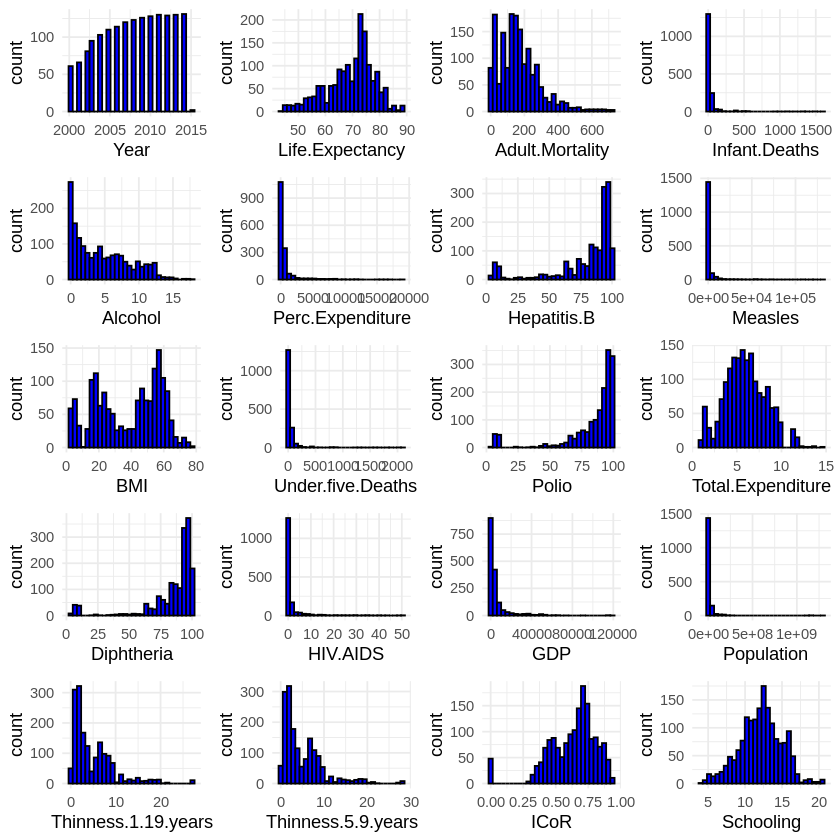

In [34]:
numeric_vars <- sapply(dataset, is.numeric)
numeric_dataset <- dataset[, numeric_vars]

hist_plots <- lapply(names(numeric_dataset), function(var) {
  ggplot(numeric_dataset, aes_string(x = var)) +
    geom_histogram(bins = 30, fill = "blue", color = "black") +
    theme_minimal()
    #ggtitle(paste('',var))
})

do.call(grid.arrange, c(hist_plots, ncol = 4))

# Diagnostic Plots of Initial Model

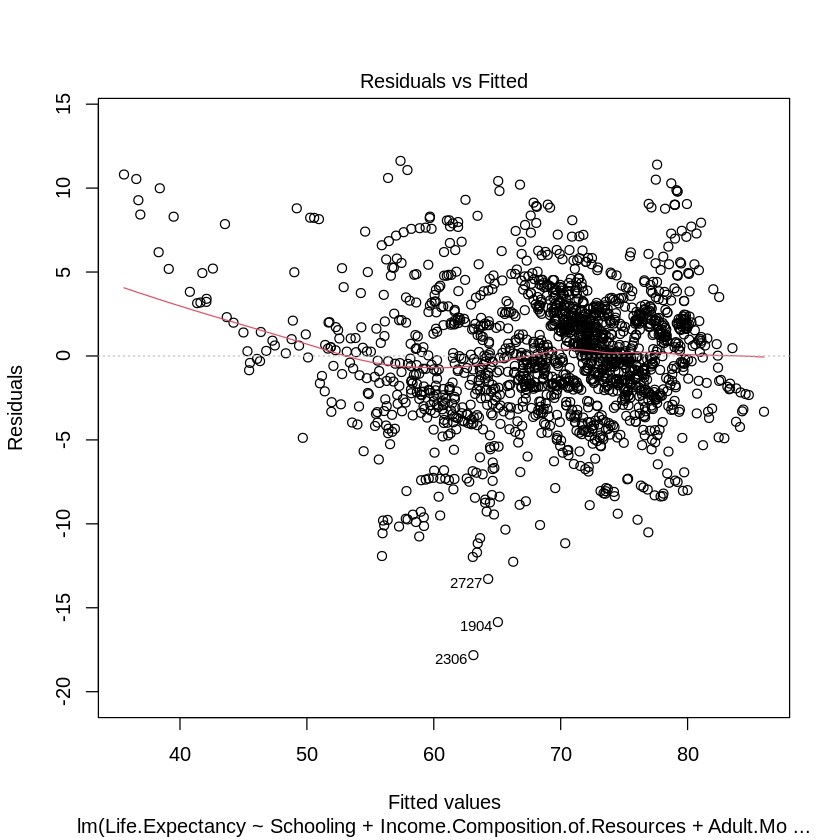

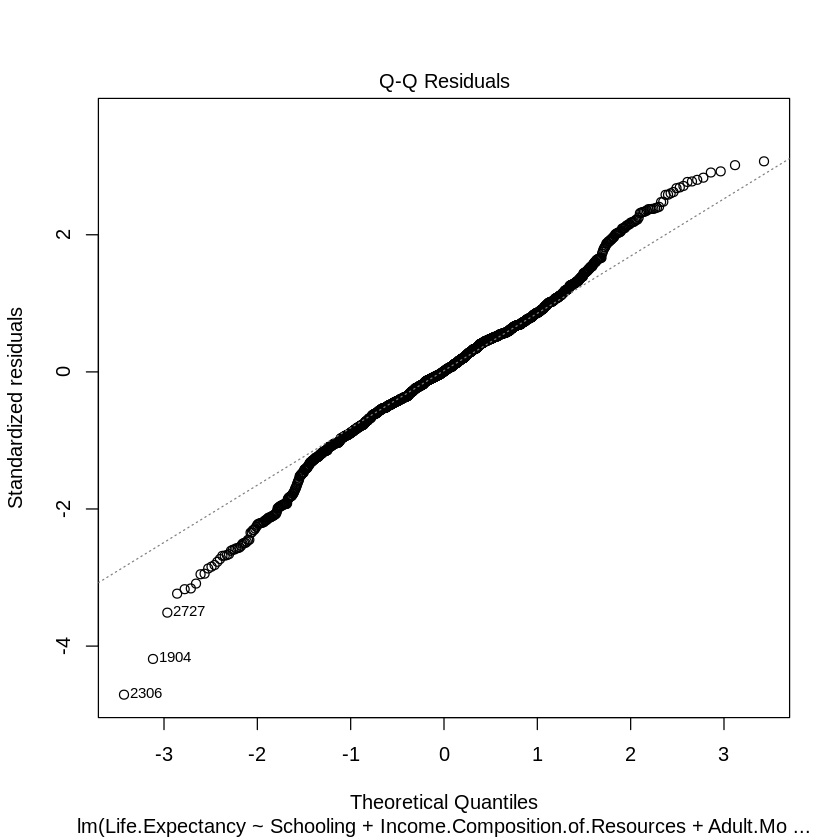

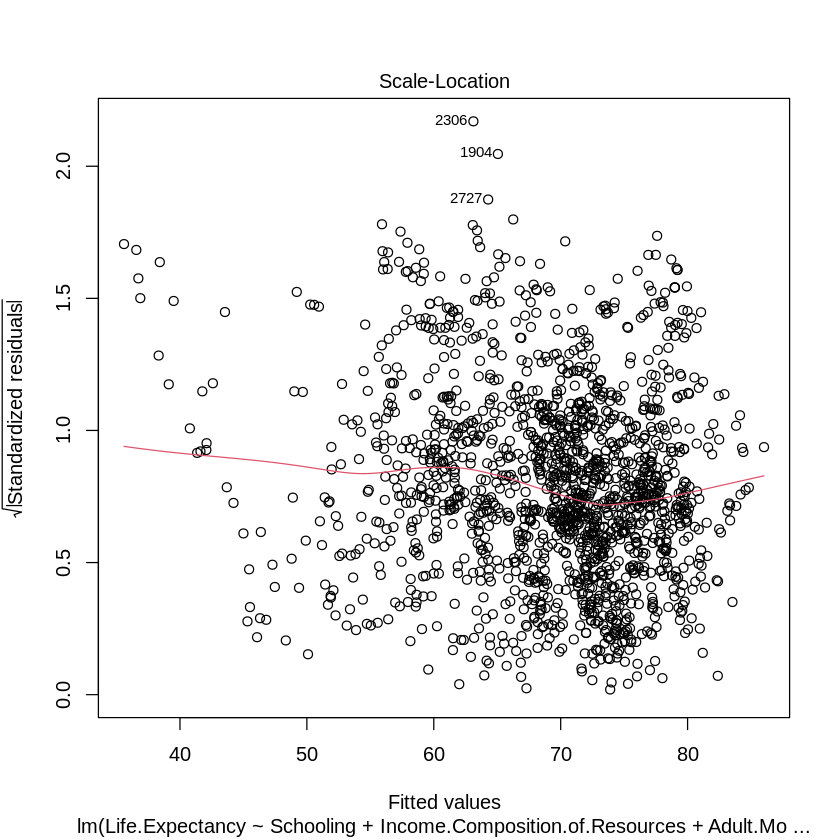

In [ ]:
model_initial <- lm(Life.Expectancy ~ Schooling + Income.Composition.of.Resources + Adult.Mortality + HIV.AIDS + BMI, data = dataset)
plot(model_initial, which = 1)
plot(model_initial, which = 2)
plot(model_initial, which = 3)

# Apply log transformation to skewed variables

In [ ]:
skewed_variables <- c("HIV.AIDS", "Under.five.Deaths", "Percentage.Expenditure", "Thinness..1.19.years")
for (var in skewed_variables) {
  dataset[[paste0(var, ".log")]] <- log(dataset[[var]] + 1)
}

# Rebuilding the Model with Transformed Variables

In [ ]:
model_variables <- c("HIV.AIDS.log", "Income.Composition.of.Resources", "Under.five.Deaths.log",
                     "Adult.Mortality", "Percentage.Expenditure.log", "Thinness..1.19.years.log",
                     "Schooling", "Diphtheria")

model_formula <- as.formula(paste("Life.Expectancy ~", paste(model_variables, collapse = " + ")))
model_transformed <- lm(model_formula, data = dataset)

# Diagnostic Plots of Transformed Model

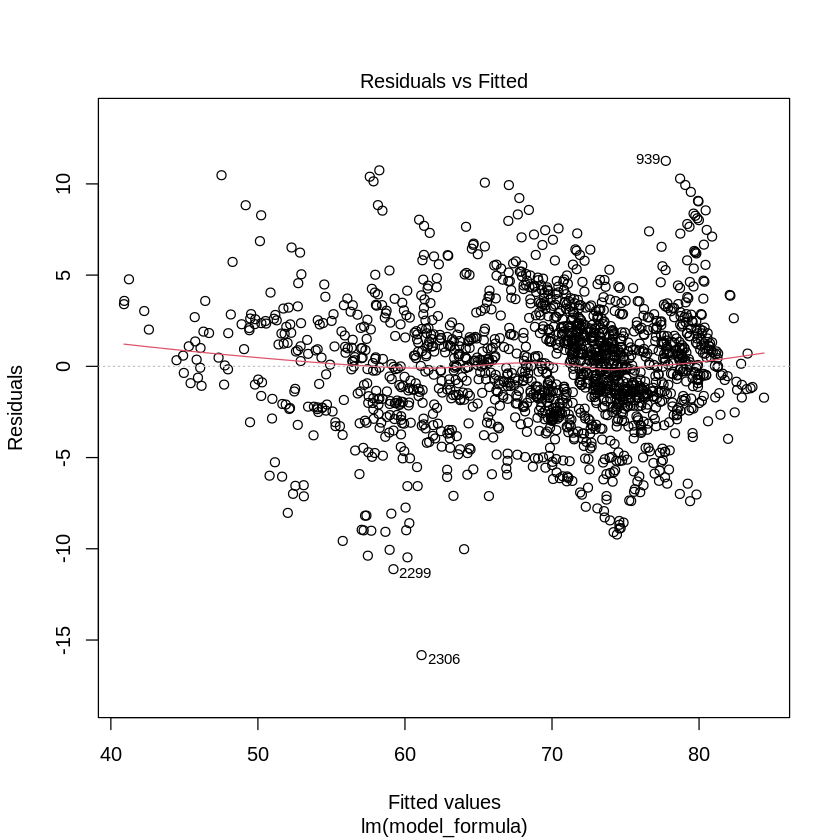

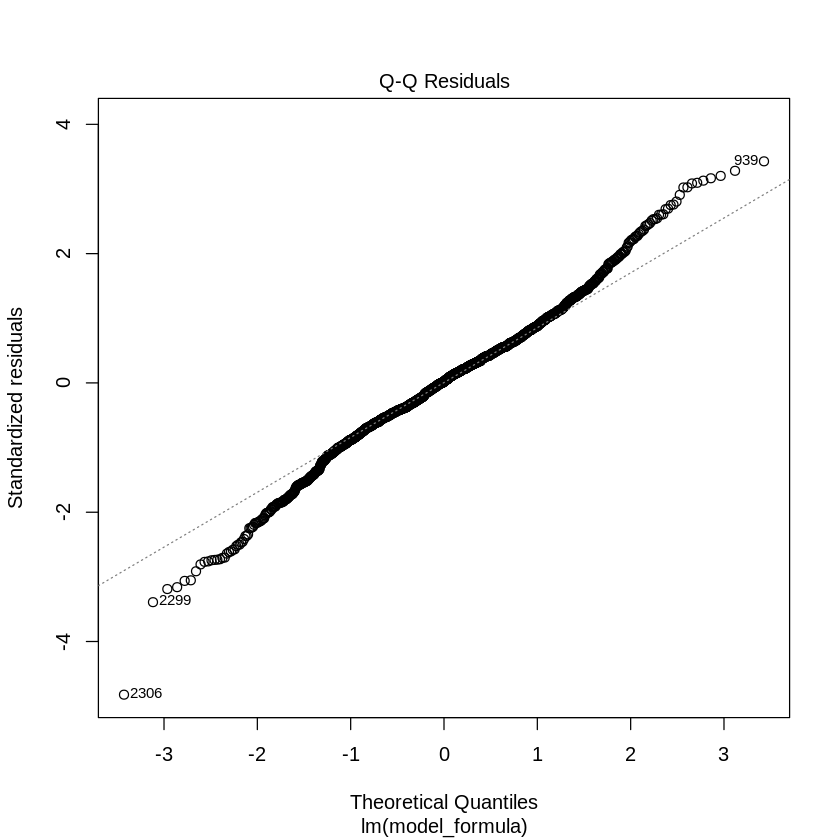

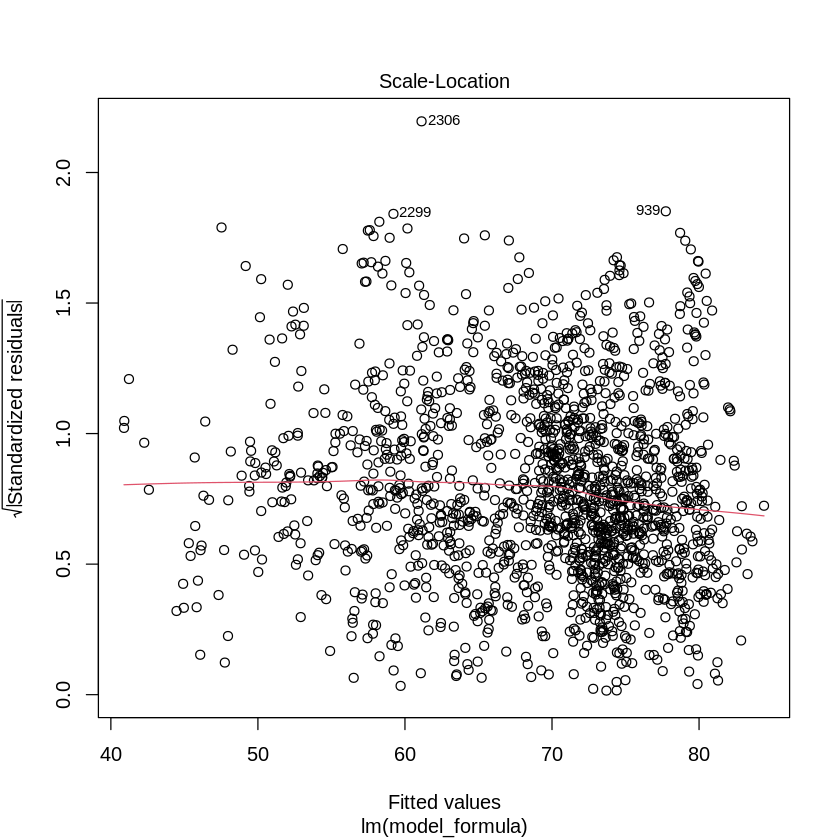

In [ ]:
plot(model_transformed, which = 1)
plot(model_transformed, which = 2)
plot(model_transformed, which = 3)

# Model summary

In [ ]:
summary(model_transformed)


Call:
lm(formula = model_formula, data = dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.8284  -1.8581   0.0738   1.9011  11.2611 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     59.4888072  0.6985943  85.155  < 2e-16 ***
HIV.AIDS.log                    -4.4265268  0.1384257 -31.978  < 2e-16 ***
Income.Composition.of.Resources  9.5351453  0.7516086  12.686  < 2e-16 ***
Under.five.Deaths.log           -0.3712840  0.0585788  -6.338 3.00e-10 ***
Adult.Mortality                 -0.0132044  0.0008901 -14.834  < 2e-16 ***
Percentage.Expenditure.log       0.4648117  0.0544239   8.541  < 2e-16 ***
Thinness..1.19.years.log        -0.8382927  0.1438908  -5.826 6.82e-09 ***
Schooling                        0.5667550  0.0538831  10.518  < 2e-16 ***
Diphtheria                       0.0138920  0.0040765   3.408 0.000671 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual sta

# Histograms for log-transformed variables

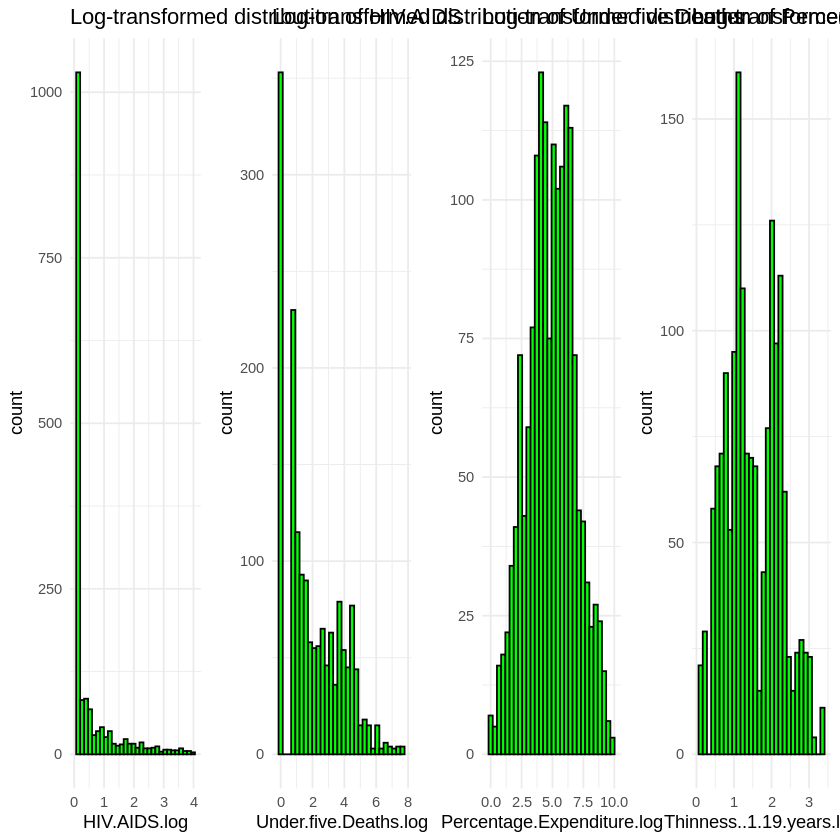

In [ ]:
log_hist_plots <- lapply(paste0(skewed_variables, ".log"), function(var) {
  ggplot(dataset, aes_string(x = var)) +
    geom_histogram(bins = 30, fill = "green", color = "black") +
    theme_minimal() +
    ggtitle(paste("Log-transformed distribution of", gsub(".log", "", var)))
})

do.call(grid.arrange, c(log_hist_plots, ncol = 4))

# Hold-out

In [ ]:
trainIndex = createDataPartition(dataset$Life.Expectancy, p = .67,
                                 list = FALSE,
                                 times = 1)

Train = dataset[trainIndex,]
Test = dataset[-trainIndex,]

summary(Train$Life.Expectancy)

model_transformed_training <- lm(model_formula, data = Train)

predicted <- predict(model_transformed_training, Test)

actual <- Test$Life.Expectancy
Error.vector <- actual - predicted
AE.vector <- abs(Error.vector)
MRE.vector <- AE.vector / actual
MER.vector <- AE.vector / predicted

error_metrics <- list(
  ME = mean(Error.vector),
  MdE = median(Error.vector),
  MAE = mean(AE.vector),
  MdAE = median(AE.vector),
  MMRE = mean(MRE.vector),
  MdMRE = median(MRE.vector),
  MMER = mean(MER.vector),
  MdMER = median(MER.vector)
)

print(error_metrics)

range(predicted)
range(actual)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  44.30   64.35   71.70   69.33   75.00   89.00 

$ME
[1] -0.2593628

$MdE
[1] -0.08624972

$MAE
[1] 2.495179

$MdAE
[1] 1.977594

$MMRE
[1] 0.03722309

$MdMRE
[1] 0.02747561

$MMER
[1] 0.03661368

$MdMER
[1] 0.02821738



[1] 41.75159 82.89252

[1] 44 89